In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torchaudio
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## preparations

In [2]:
# preprocesses the input audio and returns 
#   - spectrogram of input audio needed for result visualisation later
#   - tensor ready to process through model

def preprocess(filepath):
    # resampling to 22050Hz, to mono
    wf, sr = torchaudio.load(filepath)
    resample = torchaudio.transforms.Resample(orig_freq=sr, new_freq=22050)
    wf = resample(wf)
    wf = torch.mean(wf, dim=0)

    # transform to spectrogram
    make_spectrogram = torchaudio.transforms.Spectrogram(n_fft=510, hop_length=259, power=None, return_complex=True)
    input_spec = make_spectrogram(wf)

    # split in real and imaginary numbers
    input_tensor = torch.empty(size=list([2] + list(input_spec.shape)))
    input_tensor[0] = input_spec.real
    input_tensor[1] = input_spec.imag

    # create batch for input in neural network
    input_batch = torch.split(input_tensor, 256, dim=-1)
    if ((input_tensor.shape[-1]%256) != 0):
        input_batch = torch.stack(input_batch[:-1])
    else:
        input_batch = torch.stack(input_batch)
    
    return input_spec, input_batch

## processing

In [6]:
path_to_model = 'training_results/nn_classifier_statedict.pt'
path_to_audio = 'witchfucker-dunkel.wav'

# load model
from cnn_model import CNN

model = CNN()
model.load_state_dict(torch.load(path_to_model, map_location=device))
model.eval()

input_spec, input_batch = preprocess(path_to_audio)
result = model(input_batch)

## postprocessing

In [7]:
input_spectrogram = input_spec.log2().real.numpy()

# softmax layer for getting probabilities
result = nn.Softmax(dim=1)(result).detach().numpy()

# get the genre for each audio chunk
input_genre = pd.Series([np.where(i==i.max())[0][0] for i in result], dtype='int')
input_genre.replace(
    {0: 'disco', 1: 'metal', 2: 'blues', 3: 'jazz', 4: 'country', 5: 'hiphop', 6: 'rock', 7: 'classical', 8: 'pop', 9: 'reggae'}, inplace=True)
input_genre = input_genre.tolist()

# ascertain where the genre changes during the song
genre_change = []
for step in np.arange(len(input_genre)):
    if (input_genre[step]!=input_genre[step-1]):
        genre_change.append(step)

## result

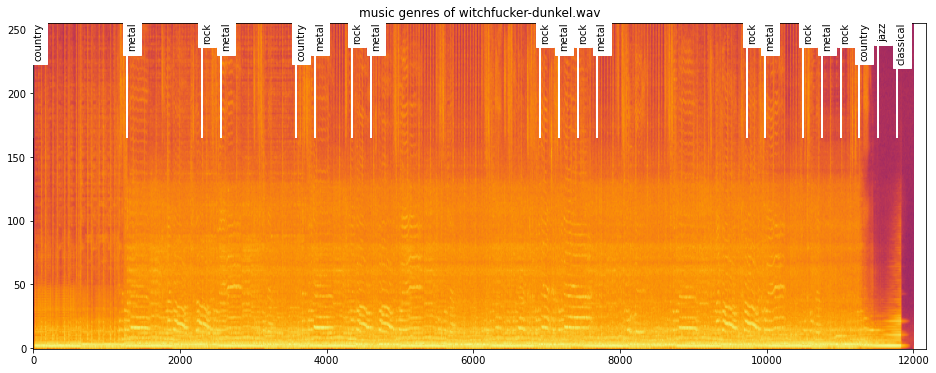

In [10]:
plt.figure(figsize=(16, 6))
plt.imshow(input_spectrogram, origin='lower', cmap='inferno', aspect='auto')

for step in genre_change: 
    plt.axvline(step*256, .65, 1, color='white', linewidth=2)
    plt.text(x=step*256, y=256, s=input_genre[step], rotation='vertical', horizontalalignment='left', verticalalignment='top', backgroundcolor='white')

plt.title(f'music genres of {path_to_audio}')
plt.savefig('images/output.jpg', dpi=300, bbox_inches='tight')
plt.show()